In [1]:
# imports and path setup
# Why: import libraries and make sure Python can find the local package under ../src or installed package.
import sys
sys.path.append('../src/') 
import pandas as pd
from datahabit import (
    TaskData, DataCleaner, BehaviorAnalyzer, PatternDetector,
    DeadlinePredictor, DifficultyEstimator, HabitScore,
    Visualizer, ReportGenerator
)

# quick versions check (helpful to debug mismatched code)
import inspect
print("TaskData file:", inspect.getfile(TaskData))
print("DataCleaner attrs:", [a for a in dir(DataCleaner) if not a.startswith("_")][:10])


TaskData file: C:\Users\airad\anaconda3\Lib\site-packages\datahabit\task_data.py
DataCleaner attrs: ['convert_all', 'fix_missing', 'is_blank', 'parse_timestamp', 'validate_timestamp']


In [2]:
# load dataset and inspect
# Why: confirm file path, preview columns and types, check for missing values
df = pd.read_csv('../datasets/ds2b_data.csv') 

# show first rows and columns to validate assumptions
print("shape:", df.shape)
print("columns:", df.columns.tolist())
display(df.head())

# quick counts of nulls in key columns
print("nulls - submission_time:", df['submission_time'].isna().sum(),
      "due_date:", df['due_date'].isna().sum(),
      "student_id:", df['student_id'].isna().sum())


shape: (19, 21)
columns: ['student', 'student_id', 'study_hours', 'sleep_hours', 'task_completed', 'distractions_count', 'day', 'start_time', 'end_time', 'productivity_score', 'task_name', 'start', 'due_date', 'submission_time', 'week', 'consistency', 'breaks_taken', 'average_focus_minutes', 'Duration (hrs)', 'complexity', 'energy_required']


,student,student_id,study_hours,sleep_hours,task_completed,distractions_count,day,start_time,end_time,productivity_score,...,start,due_date,submission_time,week,consistency,breaks_taken,average_focus_minutes,Duration (hrs),complexity,energy_required
0,Aira Grettel Dahe,2024245901,7.0,4,3,3,Wednesday,8:30,15:00,82,...,11/7/2025,2025-12-13 10:00:00,2025-12-13 9:00:00,2,88,4,52,7,High,High
1,Armisty Genia Java,2024300450,3.0,5,3,2,Monday,13:10,18:00,78,...,12/8/2025,2025-12-10 23:59:00,2025-12-12 5:25:00,2,85,3,48,5,Medium,Medium
2,Carmel Marianne Hayag,2024300972,5.0,7,2,5,Thursday,12:00,17:00,70,...,11/3/2025,2025-12-14 14:00:00,2025-12-10 11:50:00,3,80,6,44,5,High,High
3,Karylle Dellosa,2024300111,4.0,5,3,5,Tuesday,10:00,14:00,72,...,11/20/2025,2025-12-04 22:00:00,2025-11-30 23:00:00,3,78,5,45,4,High,High
4,Rodney Trillo,2024161301,NaN,8,1,7,Friday,19:00,21:00,56,...,12/3/2025,2025-12-08 8:30:00,2025-12-10 8:00:00,4,60,7,38,2,High,Medium


nulls - submission_time: 0 due_date: 0 student_id: 0


In [4]:
# normalize column names so code below doesn't break if names differ slightly
# Why: enforce consistent keys used by TaskData and the rest of the pipeline.

df = df.rename(columns=lambda c: c.strip())   # remove accidental leading/trailing spaces

In [5]:
# parse timestamps into pandas datetime (robust)
# Why: many operations (PatternDetector, TaskData) expect datetimes, not raw strings.
# We create a new parsed column so raw data is always preserved.

df['submission_time_parsed'] = pd.to_datetime(df['submission_time'], errors='coerce')
df['due_date_parsed'] = pd.to_datetime(df['due_date'], errors='coerce')

# show how many failed to parse so you can inspect bad rows
bad_submissions = df['submission_time_parsed'].isna().sum()
bad_duedates = df['due_date_parsed'].isna().sum()
print(f"Failed to parse submission_time: {bad_submissions}, due_date: {bad_duedates}")

# show a few problematic examples if any
if bad_submissions > 0:
    display(df[df['submission_time_parsed'].isna()].head())


Failed to parse submission_time: 0, due_date: 0


In [6]:
# create TaskData objects for a single student (step-by-step)
# Why: test the object creation logic on a small subset before doing everything.
student_sample = df['student_id'].iloc[0]
print("Example student_id:", student_sample)

student_df = df[df['student_id'] == student_sample].copy()
print("rows for this student:", len(student_df))

tasks = []
for i, row in student_df.iterrows():
    # Use parsed timestamps and skip rows missing required fields
    if pd.isna(row['submission_time_parsed']):
        print("skip row due to bad submission_time:", i)
        continue
    if pd.isna(row['student_id']) or pd.isna(row['task_name']):
        print("skip row due to missing student/task:", i)
        continue

    # Create TaskData — pass submission_time as parsed datetime
    try:
        td = TaskData(
            row['student_id'],
            row['task_name'],
            row['submission_time_parsed']
        )
        tasks.append(td)
    except Exception as e:
        print("TaskData creation error at row", i, ":", e)

print("created TaskData objects:", len(tasks))
# peek at first TaskData
if tasks:
    print(tasks[0])


Example student_id: 2024245901
rows for this student: 1
created TaskData objects: 1
TaskData(student=2024245901, task='OOP Project', submitted='2025-12-13 09:00:00')


In [9]:
# Behavior analysis for the single student
# Why: compute delays, classify, and see statistics — confirms pipeline works for one user.

if not tasks:
    raise SystemExit("No task objects for sample student. Fix parsing or sample selection first.")

ba = BehaviorAnalyzer(tasks)

# classify_behavior accepts global due_date if TaskData doesn't store due dates
# pass the student's first parsed due_date as a global example (or pick a course-level due date)
due_series = student_df['due_date_parsed'].dropna()
global_due = due_series.iloc[0] if len(due_series) > 0 else None

label = ba.classify_behavior(global_due)
stats = ba.get_statistics()
print("Behavior label:", label)
print("Statistics:", stats)


Behavior label: Consistent Worker
Statistics: {'tasks_analyzed': 1, 'avg_delay_hours': -1.0, 'std_dev_delay': 0, 'behavior_label': 'Consistent Worker'}


In [10]:
# pattern detection
# Why: detect time-of-day habits (morning/night/afternoon/evening)
pattern = PatternDetector()
for ts in student_df['submission_time_parsed']:
    if pd.notna(ts):
        pattern.add_submission(ts)

print("Detected pattern:", pattern.detect_pattern())


Detected pattern: Morning Worker


In [11]:
# deadline prediction (uses delay history)
# Why: show predicted next submission datetime based on historic average delay

predictor = DeadlinePredictor()
for t in tasks:
    # we pass the same global due used previously
    predictor.add_delay(t.get_delay(global_due))

pred_hours = predictor.predict_next_delay()
predicted_date = predictor.predict_submission_date(global_due or "2025-12-30 23:59")
print("Predicted average delay (hours):", pred_hours)
print("Predicted next submission datetime:", predicted_date)


Predicted average delay (hours): -1.0
Predicted next submission datetime: 2025-12-13 09:00:00


In [12]:
# difficulty estimator and habit score
# Why: find tasks with longest average delays and compute a compact habit score

difficulty = DifficultyEstimator()
habit = HabitScore()

for t in tasks:
    delay = t.get_delay(global_due)
    difficulty.record_task(t._task_name, delay)
    habit.add_delay(delay)

print("Top difficult tasks:", difficulty.get_difficult_tasks())
print("Habit score (0-100):", habit.compute_score())


Top difficult tasks: [('OOP Project', -1.0)]
Habit score (0-100): 100


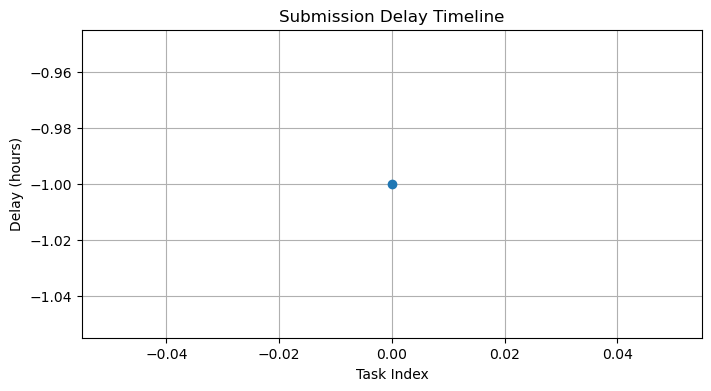

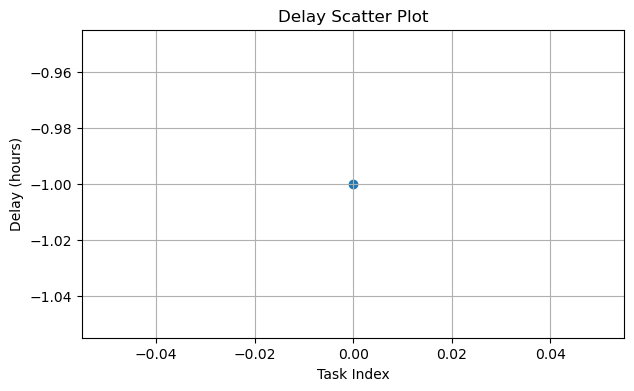

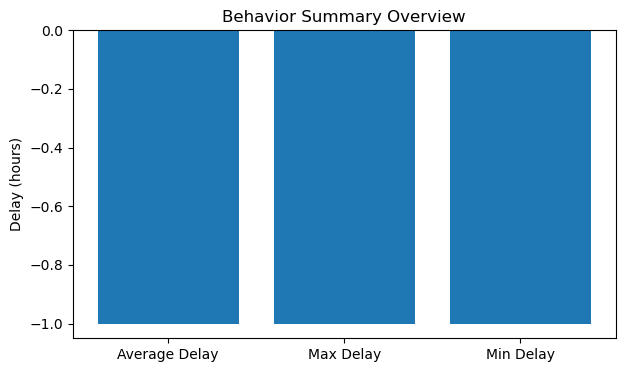

In [13]:
# visualization
# Why: quick visual sanity checks to show timeline and scatter of delays
delays = [t.get_delay(global_due) for t in tasks]
viz = Visualizer(delays)

# these will pop up inline in Jupyter; set show=True (default)
viz.plot_timeline()
viz.plot_scatter()
viz.plot_summary()
